In [4]:
%matplotlib inline
import matplotlib.pyplot as plt, seaborn as sn, numpy as np, pandas as pd
sn.set_context('notebook')

# Beyond Metropolis: a more realistic example

As discussed in the previous notebook, the Metropolis algorithm is the basic building block of MCMC. It is *guaranteed* to converge on the target distribution, but convergence will be *more efficient* if the **jump** (or **proposal**) distribution is similar to the target. This motivates the development of **adaptive** algorithms, where the proposal distribution is "tuned" as the Markov chain progresses.

There are lots of ways of implemeting adaptation (as well as various other innovations for improving the sampling efficiency), but a detailed description of modern MCMC algorithms is beyond the scope of these notes. What's more, if you're a hydrologist or an ecologist (rather than a statistician), you're probably more interested in *applying* MCMC, rather than learning about all the mathematical details. Fortunately, if you understand the principles of the Metropolis algorithm (see notebook 4), you should be in a good position to use some more sophisticated MCMC packages without having to worry about the algorithms themselves.

## 1. Useful Python packages

In this notebook, we'll start off by introducing two Python packages that implement a variety of state-of-the-art MCMC algorithms. We'll then illustrate the *entire model development and calibration process* by building a very basic hydrological model from scratch, and then calibrating it using some real data and a powerful, modern MCMC algorithm.

### 1.1. PyMC3

**[PyMC3]('https://github.com/pymc-devs/pymc3')** is a Python package offering a variety of sophisticated MCMC samplers, including **Hamiltonian Monte Carlo (HMC)** and the **No U-Turn Sampler (NUTS)**. It also provides a very clean syntax for model specification (defining priors, likelihoods etc.), as well as convenience functions for a wide range of distributions. This makes setting up a model and running MCMC very simple: as an illustration, check out the **linear regression** example in the [PyMC3 tutorial]('http://pymc-devs.github.io/pymc3/getting_started/'). This is very similar to the example covered in notebook 4, except there we coded everything from scratch and used only a basic Metropolis algorithm. With PyMC3, the number of lines of code is dramatically reduced and we have the added advantage of being able to switch easily between several modern samplers.

However, a key property of the HMC and NUTS algorithms is they use the **gradient** of the target function to help tune the proposal distribution. This gives excellent performance for high-dimensional problems, but requires the target function to be **differentiable**. Unfortunately, as we have already seen in notebook 3, for complex environmental models the likelihood function is often not well-behaved, so the posterior distribution is not differentiable and many of the advantages of the HMC and NUTS algorithms are lost.

### 1.2. emcee

**[emcee]('http://dan.iel.fm/emcee/current/')** is Python package which implements an **affine invariant MCMC ensemble sampler** (a more detailed description of the algorithm from the package authors is [here]('http://arxiv.org/abs/1202.3665')). This sampler uses **multiple chains** together with some clever mathematical "tricks" to tune the proposal distribution *without* requiring gradient information. This makes it ideal for the kinds of complex likelihoods commonly encountered in environmental modelling. Furthermore, although in high-dimensional parameter spaces the HMC or NUTS algorithms *may* be more efficient, the multiple chains used by emcee are easy to parallelise (see notebook 4), which offers a significant performance advantage.

The downside of emcee is that, unlike PyMC3, there are no easy ways to specify your model: you have to write Python functions from scratch to represent your priors, likelihood and posterior. For simple models, this is not a major limitation, but for more complex likelihoods (e.g. more sophisticated error structures) the process can become time consuming.

[It is possible]('http://twiecki.github.io/blog/2013/09/23/emcee-pymc/') that the emcee algorithm will eventually be integrated into PyMC3, but in the meantime I recommend investigating both packages as they're useful in different situations. 

In the example below we'll use emcee.

## 2. A hydrological example

We're going to illustrate everything we've covered so far using a highly simpified but slightly more realisitc example. We'll formulate a very basic hydrological model to simulate flows in a small Scottish catchment. The model will be too simplistic for any real-world application, but I hope it will provide a useful illustration of the modelling process. We'll then use emcee to calibrate the model and see what we can learn about the model parameters *given some real data*.

### 2.1. The study catchment

We're going to use some data from the **Tarland catchment** in Aberdeenshire, Scotland. Flow data are available from 2001 to 2010, together with rainfall and potential evapotranspiration (PET) datasets for the same period that we'll use to drive our model. The catchment has an area of $51.7\,km^2$ and we'll be using flow data from the gauging station at **Coull**.

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeWXluaE9wMGtnMUk" alt="Tarland catchment map" height="700" width=700> 

It is important to stress that *all* of these datasets are subject to **error**. For example:

  1. The **rainfall data** come from spatially interpolated rain gauge measurements. Rain gauges are notoriously inaccurate (especially in Scotland where it's often raining horizontally) and the spatial interpolation process adds further uncertainty <br><br>
  
  2. The **PET data** have been estimated using the **[FAO56 modified Penman-Monteith method]('http://www.fao.org/docrep/x0490e/x0490e00.htm')**. This is a whole model in itself, incorporating data on cloud cover, solar radiation, humidity, wind speed, temperature etc., all of which are imperfectly measured. The version of the method used here also assumes that the land cover is uniform grass of an even height, which is not the case in the Tarland catchment <br><br>
  
  3. The **flow data** are based on an empirically derived **[stage-discharge relationship]('http://water.usgs.gov/edu/streamflow3.html')** which is subject to considerable uncertainty due to changing riverbed sediments and limited gauging data, especially for high flows
  
Understanding the limitations of the data is important and in a more comprehensive analysis we might attempt to incorporate uncertainty about our input and calibration data into our likelihood function. Even if we do not do this, we should certainly spend some time **quality checking** the data and perhaps **cleaning or removing points that are obviously spurious**. For the simple example presented here, we will *ignore all these issues* and instead focus only on the **parameter-related uncertainty** in our model. This is an important omission, but I want to keep the example as simple as possible.

The precipitation and flow data have a **daily** time step, whereas the PET data are **monthly**. For now, we'll simply assume that the monthly PET totals are distributed evenly over each day of the month.

Note that throughout this entire analysis, all water **volumes** will be expressed in **millimetres**. This is not a mistake - we're simply performing all the calculations **per unit area** so that we can visualise what's going on in terms of a 2D conceptualisation (see below). In reality, the Tarland catchment has an area of $51.7 \, km^2$, so a rainfall input of 1 mm equates to an actual water volume of $1 \times 10^{-3} * 51.7 \times 10^6 = 51.7 \times 10^3 \, m^3$. 

In [5]:
# Download Tarland data into a Pandas dataframe
data_url = r'https://drive.google.com/uc?export=&id=0BximeC_RweaecHNIZF9GMHkwaWc'
met_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col=0)

# Convert cumecs to mm
cat_area = 51.7E6 # Catchment area in m2
met_df['Runoff_mm'] = met_df['Q_Cumecs']*60*60*24*1000/cat_area
del met_df['Q_Cumecs']

# Linear interpolation of any missing values
met_df.interpolate(method='linear', inplace=True) 

print met_df.head()

# Calculate annual averages for rainfall, PET and runoff
ann_df = met_df.resample('A', how='sum')
print '\nAnnual averages:'
print ann_df.mean()

            Rainfall_mm  PET_mm  Runoff_mm
Date                                      
2000-01-01         0.10    0.72   1.297504
2000-01-02         1.00    0.72   1.304857
2000-01-03         1.10    0.72   1.220296
2000-01-04         1.38    0.72   1.155955
2000-01-05         3.62    0.72   1.167152

Annual averages:
Rainfall_mm    965.661818
PET_mm         529.885455
Runoff_mm      458.833117
dtype: float64


Broadly speaking, these annual averages are about what would be expected for a catchment like the Tarland in Eastern Scotland, with the exception that the PET losses are rather too high. This is partly because the FAO56 PET calculation (linked above) assumes the land cover is grass with no moisture stress, whereas the actual land cover in the Tarland is mixture of agriculture, forestry, rough grazing and upland vegetation. For comparison, according to the **[UK Hydrometric Register]('http://nora.nerc.ac.uk/3093/1/HydrometricRegister_Final_WithCovers.pdf')**, the Girnock Burn at Littlemill (a little to the southwest of the Tarland) has a long term average annual rainfall of $998 \, mm$ and a mean annual runoff of $554 \, mm$. This means the **actual evapotranspiration (AET)** (plus other losses) accounts for around $454 \, mm$ per year. For Tarland, we're not going to worry about this too much, but we will build a simple *correction factor* into our model to modify the unreasonably high rate of PET.

### 2.2. A conceptual hydrological model

We are going to represent the entire Tarland catchment as **two connected "buckets"**, one representing the **soil water** reservoir and the other representing the **groundwater**. This approach is very common in hydrology, except most practically useful models break the system down into more buckets. For example, some models use different buckets for different combinations of land cover and soil type (often called "**hydrological response units**"); others divide the subsurface into more than two reservoirs, by having e.g. separate "buckets" for shallow versus deep groundwater, and perhaps the same for soil water too. There are many variations on this theme, and once you have lots of buckets there are numerous ways of linking them together, which leads to consideration of e.g. water travel times along different river reaches and between different water stores. 

All this adds to the complexity of the model and can quickly lead to **over-parameterisation** (as described in notebook 2). We're going to *ignore all of these complexities as well* and just consider two simple buckets. With such a basic setup we certainly can't be accused of over-parameterisation, but equally it's unlikely that this model will be very informative in terms of understanding the hydrology of the Tarland catchment.

<img src="https://drive.google.com/uc?export=&id=0BximeC_RweaeM2VqUDAtN0dqS28" alt="Two bucket model" height="400" width=400> 

#### Soil reservoir

For the soil reservoir, we will assume the only water input is the precipitation, $P$. The outputs are **potential** evapotranspiration, $\alpha E$, and soil drainage, $S$. $\alpha$ is a correction factor between $0$ and $1$, which we will use to reduce the Penman-Monteith PET rates to more realistic values. Because we don't know what an appropriate value for $\alpha$ should be, we will include it as a parameter in our calibration procedure.

The soil reservoir has a **[field capacity](https://en.wikipedia.org/wiki/Field_capacity)**, $V_{fc}$, which is the amount of water the soil "likes to hold onto" under freely draining conditions. We will assume that soil drainage only takes place when the water level in the soil is greater than the field capacity i.e. when $V_s > V_{fc}$. Below field capacity no drainage will take place, but water can still be removed from the soil by evapotranspiration. 

We will further assume that the soil drainage, $S$, is directly proportional to the volume of water *above field capacity*. The constant of proportionality in this relationship is $\frac{1}{\tau_s}$, where $\tau_s$ is known as the **soil water residence time**. This is the average length of time (in days) that a molecule of water spends in the soil between flowing in and flowing out.

$$S = \frac{(V_s - V_{fc})}{\tau_s}$$

[As an aside, it's worth mentioning that this assumption has at least some physical basis: the equation represents the behaviour of a bucket with a hole in the bottom **filled with some porous material** (e.g. soil or sediment) such that the flow of water through the hole is **laminar**. Note that without the porous material the equation would be different.]

The equation above suggests negative values for $S$ whenever $V_s$ is below field capacity, which is undesirable. To correct for this, we will introduce a function, $g(V_s)$, to set the soil drainage to zero when $V_s < V_fc$. One obvious choice for $g(V_s)$ would be

$$g(V_s) = 0 \qquad for \qquad V_s \leq V_{fc}$$
$$g(V_s) = 1 \qquad for \qquad V_s > V_{fc}$$

However, this would intoduce non-differentiable discontinuities that could cause problems later. Instead, we can use the **[sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function)**, which has the form

$$g(V_s) = \frac{1}{1 + e^{a - V_s}}$$

If we set the constant $a$ in this equation equal to the field capacity, we obtain a curve which switches very rapidly from approximately zero to approximately 1 when $V_s = V_{fc}$:

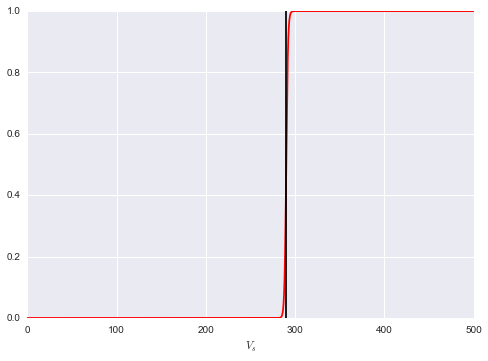

In [6]:
# Sigmoid function
fc = 290

Vs = np.arange(0, 500, 0.1)
g_Vs = 1/(1 + np.exp(fc - Vs))

plt.plot(Vs, g_Vs, 'r-')
plt.axvline(fc, c='k')
plt.xlabel('$V_s$')
plt.show()

This version of $g(V_s)$ has the advantaged of being differentiable. We can therefore define the outflow from the soil reservoir, $S$, as

$$S = \frac{(V_s - V_{fc})}{\tau_s}g(V_s) = \frac{(V_s - V_{fc})}{\tau_s(1 + e^{V_{fc} - V_s})}$$

Finally we know that, in reality, **actual** evapotranspiration (AET) differs from **potential** evapotranspiration (PET). One reason for this is that, as the soil dries out, it becomes increasingly difficult to evaporate more water i.e. it is easier to evaporate $1 \; mm$ of water from a wet soil than from a nearly-dry soil. It is often assumed that moisture-limited evapotranspiration begins when the water level falls below field capacity. To represent this in our model we will include an additional correction factor for PET that is a function of soil moisture, $f(V_s)$. In terms of choosing an appropriate function, we want something that tends to $1$ as $V_s$ approaches $V_{fc}$ and tends to $0$ as $V_s$ tends to $0$. Two possible choices are:

$$f(V_s) = 1 - e^{-\mu V_s} \qquad or \qquad f(V_s) = \frac{V_s}{\mu + V_s}$$

where $\mu$ is a tuning parameter that determines the shape of the curves. If we calculate AET as $\alpha E f(V_s)$ you should be able to see that, for either of the above choices for $f(V_s)$, when the soil is wet AET will be similar to PET, but as the soil dries out AET is progressively reduced, even if $\alpha E$ remains large.

For this example we will use the first (exponential) option for $f(V_s)$, and will attempt to choose a value for $\mu$ that is consistent with the soil properties of the Tarland catchment.  Based on information in the **[Hydrology of Soil Types (HOST)](http://www.ceh.ac.uk/services/hydrology-soil-types-1km-grid)** database, the average field capacity of soils across the Tarland as a whole is roughly $290 \; mm$. The image below superimposes this value (vertical black line) on a plot of $f(V_s) = 1 - e^{-\mu V_s}$ for a range of values of $\mu$.

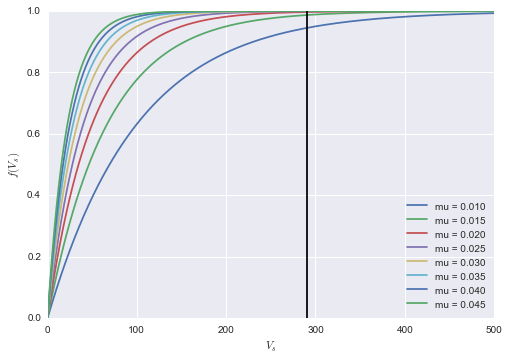

In [7]:
mus = np.arange(0.01, 0.05, 0.005) # Selection of values for mu
Vs = np.arange(0, 500, 0.5)        # Vs from 0 to above field capacity
fc = 290  # Field capacity (mm)

# Loop over mu values
for mu in mus:
    f_Vs = 1 - np.exp(-mu*Vs)
    plt.plot(Vs, f_Vs, label='mu = %.3f' % mu)

plt.axvline(fc, c='k')
plt.legend(loc='best')
plt.ylabel('$f(V_s)$')
plt.xlabel('$V_s$')
plt.show()

For the lower curve on this plot ($\mu = 0.01$), moisture limitation begins too soon: $f(V_s)$ is significantly below 1 even when the water level is well above field capacity. On the other hand, when $\mu = 0.04$, moisture limitation does not really begin until $V_s \approx 100 \; mm$, which is too low. Based on this rough investigation, $\mu = 0.02$ seems like a reasonable choice in this case because 

$$f(V_s) \approx 1 \qquad for \qquad V_s > V_{fc}$$
$$f(V_s) < 1 \qquad for \qquad V_s < V_{fc}$$

For the volume of water in the soil reservoir, we can therefore write the following differential equation based on balancing inputs and outputs

$$\frac{dV_s}{dt} = P - \alpha E (1 - e^{-0.02V_s}) - S$$

Ideally, however, we would like an equation for $\frac{dS}{dt}$, because we would like to know the amount of water leaving the soil to either the groundwater or the stream. Finding $\frac{dS}{dt}$ is not straightforward but, using the **[chain rule](https://en.wikipedia.org/wiki/Chain_rule)**, we know that

$$\frac{dS}{dt} = \frac{dV_s}{dt} \frac{dS}{dV_s}$$

We have just written down an equation for $\frac{dV_s}{dt}$ and, from the discussion above, we also have an equation for $S$ in terms of $V_s$, which we can differentiate to give $\frac{dS}{dV_s}$. The differential can be calculated by hand using the **[product rule}(https://en.wikipedia.org/wiki/Product_rule)** or, if you're feeling lazy, you can always try **[Wolfram Alpha](http://www.wolframalpha.com/input/?i=derivative+%28x-+a%29%2F%28b*%281+%2B+exp%28a+-+x%29%29%29)** instead. The result is that if

$$S = \frac{(V_s - V_{fc})}{\tau_s(1 + e^{V_{fc} - V_s})}$$

then

$$\frac{dS}{dV_s} = \frac{(V_s - V_{fc})e^{V_{fc} - V_s}}{T_s(e^{V_{fc} - V_s} + 1)^2} + \frac{1}{T_s(e^{V_{fc} - V_s} + 1)}$$

Although this equation looks pretty horrible, it's not actually that bad and we now have everything we need to simulate the soil water reservoir.

#### Groundwater reservoir

For the groundwater reservoir, we assume that a fraction, $\beta$, of the water draining from the soil reservoir moves downwards into the groundwater. The remainder of the soil drainage, $(1 - \beta S)$, is assumed to travel directly to the stream along fast, shallow flow pathways. 

$\beta$ is sometimes referred to as the **Base Flow Index (BFI)** and it can be estimated in a variety of ways. For the Tarland catchment, previous work suggests $\beta \approx 0.6$ and even though there is considerable uncertainty in this value, to keep things simple we will fix $\beta = 0.6$ in our model and will not include it in our calibration procedure.

The groundwater reservoir behaves in the same way as the soil water reservoir, except it's simpler because we don't need to worry about issues such as evapotranspiration and field capacity. The rate of change of volume in the groundwater is equal to the balance of inputs and outputs

$$\frac{dV_g}{dt} = \beta S - G$$ 

and the outflow from the groundwater is directly proportional to the groundwater storage volume

$$G = \frac{1}{\tau_g}V_g$$

As above, we are primarily interested in $\frac{dG}{dt}$, which we can calculate using the chain rule

$$\frac{dG}{dt} = \frac{dV_g}{dt} \frac{dG}{dV_g}$$

From these equations we can write

$$\frac{dG}{dt} = \frac{\beta S - G}{T_g}$$

#### Summary of model equations

Ultimately, we want to use the model to predict the total runoff volume to the stream, $R$, at each time step

$$R = D_s + D_g$$

where $D_s$ and $D_g$ are the soil and groundwater drainage volumes respectively. To find $D_s$ and $D_g$, we must first integrate the differential equations for $S$ and $G$ to discover how these quantities vary with time i.e. given a set of model inputs, parameters and initial conditions, we can calculate the flow rates from the soil and groundwater reservoirs at any point. Furthermore, if we integrate these equations *again* we can calculate the **volume of water** draining from the two boxes within any interval of interest (this is because the area under the flow rate curve is equal to the flow volume).

To represent all this, we can write down a system of **coupled, first-order Ordinary Differential Equations (ODEs)**

$$\frac{dV_s}{dt} = P - \alpha E (1 - e^{-0.02V_s}) - S$$

$$\frac{dS}{dV_s} = \frac{(V_s - V_{fc})e^{V_{fc} - V_s}}{\tau_s(e^{V_{fc} - V_s} + 1)^2} + \frac{1}{\tau_s(e^{V_{fc} - V_s} + 1)}$$

$$\frac{dS}{dt} = \frac{dV_s}{dt} \frac{dS}{dV_s}$$

$$\frac{dG}{dt} = \frac{\beta S - G}{\tau_g}$$

$$\frac{dD_s}{dt} = (1 - \beta) S$$

$$\frac{dD_g}{dt} = G$$

### 2.3. Parameterising the model

Although this is a fairly simple model, we already have several choices to make regarding what to include in our calibration procedure. In the discussion above we have decided not to explicitly consider errors in the input time series, $P$ and $E$, or in the observed flow data, $R_{obs}$. The model itself has five parameters: $\alpha$, $\beta$, $\tau_s$, $\tau_g$ and $\mu$. We have already decided to fix $\mu = 0.02$ and $\beta = 0.6$. We will include the remaining three parameters in our calibration procedure.

## 3. Solving ODEs

Solving systems of ODEs is a large and complicated topic in itself, with quite a few pitfalls for the unwary. Within Python, a variety of tools are available, ranging from the basic solvers in [`scipy.integrate.ode`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html), to the more sophisticated options provided by [`odespy`](https://github.com/hplgit/odespy) and the full **dynamic systems modelling** capabilities of [`PyDSTool`](http://www.ni.gsu.edu/~rclewley/PyDSTool/FrontPage.html). For many real-world applications, it may be worth investigating these options in detail, but for the simple example here we will make use of [`scipy.integrate.odeint`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html), which is probably the simplest interface for solving ODEs in Python.

We'll begin with an illustration of how to solve our system for a single time step, where $P$ and $E$ are kept constant. We'll also choose fixed values for all the calibrating parameters ($\alpha$, $\tau_s$ and $\tau_g$). The idea here is just to illustrate solving the ODE system, not to actually calibrate our model.

                     V         S         G          Ds          Dg
298.798799  340.033392  5.003339  2.715576  471.293477  435.382624
299.099099  340.033392  5.003339  2.716435  471.894479  436.198242
299.399399  340.033392  5.003339  2.717291  472.495481  437.014116
299.699700  340.033392  5.003339  2.718145  473.096483  437.830248
300.000000  340.033392  5.003339  2.718996  473.697484  438.646635


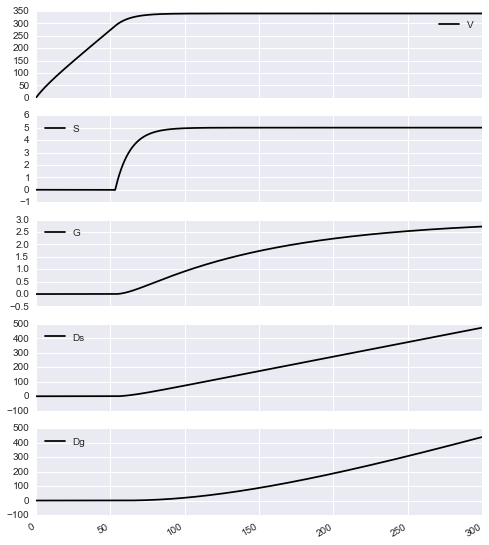

In [30]:
from scipy.integrate import odeint

# Model parameters
alpha = 0.75    # PET correction factor (dimensionless)
beta = 0.6      # BFI (dimensionless)
T_s = 10.       # Soil residence time (days)
T_g = 100.      # Groundwater residence time (days)
fc = 290        # Field capacity (mm)
step_len = 300  # Time step length (days)

# Initial conditions
P = 8.         # Precipitation (mm/day)
E = 4.         # PET (mm/day)
Vs0 = 0.       # Initial soil volume (mm)
Vg0 = 0.       # Initial groundwater volume (mm)

# Calculate S0 and G0 from Vs0 and Vg0
S0 = (Vs0 - fc)/(T_s*(1 + np.exp(fc - Vs0)))
G0 = Vg0/T_g       

# Array of time points at which to evaluate ODEs
ti = np.linspace(0, step_len, 1000)

def f(y, t, params):
    """ Define ODE system.
            y is list [V, S, G, Ds, Dg]
            t is an array of time points of interest
            params is a tuple (P, E, alpha, beta, T_s, T_g, fc)
    """
    # Unpack incremental values for S and G
    Vi = y[0]
    Si = y[1]
    Gi = y[2]
    
    # Unpack params
    P, E, alpha, beta, T_s, T_g, fc = params

    # Model equations (see section 2.2)
    dS_dV = (((Vi - fc)*np.exp(fc - Vi))/(T_s*((np.exp(fc-Vi) + 1)**2))) + (1/(T_s*(np.exp(fc-Vi) + 1)))
    dV_dt = P - alpha*E*(1 - np.exp(-0.02*Vi)) - Si
    dS_dt = dS_dV*dV_dt
    dG_dt = (beta*Si - Gi)/T_g
    dDs_dt = (1 - beta)*Si
    dDg_dt = Gi
    
    # Add results of equations to an array
    res = np.array([dV_dt, dS_dt, dG_dt, dDs_dt, dDg_dt])
    
    return res

# Vector of initial conditions
y0 = [Vs0, S0, G0, 0, 0]

# Model parameters
params=[P, E, alpha, beta, T_s, T_g, fc]

# Solve
y = odeint(f, y0, ti, args=(params,))

# Build df of output
df = pd.DataFrame(data=y,
                  columns=['V', 'S', 'G', 'Ds', 'Dg'],
                  index=ti)
df.plot(subplots=True, figsize=(8, 10))
print df.tail()

It's worth considering these plots in detail to understand what's going on. The soil and groundwaetr buckets are initially empty, and the rates of precipitation and **potential** evapotranspiration are held constant at $8 \; mm/day$ and $4 \; mm/day$, respectively. For PET we also applied a correction factor, $\alpha = 0.75$, so the modified PET rate is really $3 \; mm/day$. However, because the soil is initially dry, the **actual** evapotranspiration is reduced to **zero** by our correcting function, $f(V_s)$. Also, because the soil water level is below field capacity, the function $g(V_s)$ keeps the soil drainage at zero, so no water drains either to the groundwater reservoir or to the stream. 

The soil water reservoir begins to fill at a rate that is initially equal to $P$. As soon as the soil becomes wet, AET can also take place at a rate governed by $f(V_s)$, so the soil reservoir continues to fill, but more slowly.

After a little over $50 \; days$, the soil reaches field capacity and soil drainage begins. At this point, $f(V_s) \approx 1$ and so $AET = PET = 3 \; mm/day$ i.e. evapotranspiration is no longer moisture limited and the net **hydrologically effective rainfall** (precipitation minus AET) is equal to $5 \; mm/day$. As the water level in the soil increases, the outflow rate also increases until $S = 5 \; mm/day$, at which point the inputs and outputs are balanced and the store achieves equilibrium. The expected steady-state water level can be determined from the equations above: as long as we are above field capacity, we know that

$$S = \frac{V_s - V_{fc}}{\tau_s}$$

We therefore expect the soil water level to stabilise at $V_s = S \tau_s + V_{fc}$, which for this example is $340 \; mm$. This is confirmed by the plot above.

Once drainage from the soil begins, the water level in the groundwater also starts to rise. In this example, the groundwater reservoir is slower to respond than the soil store ($\tau_g = 100 \; days$; $\tau_s = 10 \; days$), so the outflow rate, $G$, increases more slowly. At equilibrium, the inflow rate to the groundwater is equal to $\beta S = 3 \; mm/day$. It is clear from the plot that the groundwater outflow rate is slowly approaching this value, but has not quite reached steady-state in the $300$ time steps simulated.